<a href="https://colab.research.google.com/github/arjoca/RHDocentes/blob/main/RHDocentes_Hoje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RHDocentes - fevereiro 2022

**Notebook 1** - O ISEL Hoje e as Desigualdades

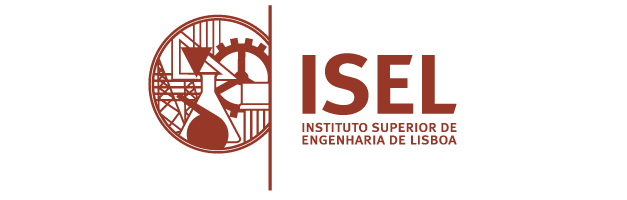

Estudo organizado em 3 notebooks:
*   **Este notebook** - O ISEL Hoje e as Desigualdades 
*   [O próximo](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Futuro.ipynb) - O Futuro e a Dinâmica de Aposentações
*   [O último](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Corrige.ipynb) - Correção das Desigualdades

# Fontes de informação

*   Ficheiro "Afetacao_Financeira_ADs_Cursos_2021_v01.xlsx"
*   Ficheiro "RAIDES_0.xlsx"

Informação que depois de filtrada e anonimizada deu origem aos dados guardados no ficheiro [clean_data.xlsx](https://github.com/arjoca/RHDocentes/blob/main/data/clean_data.xlsx), usados neste estudo.

# Preparação

## Importação de módulos e leitura de dados

In [1]:
# Instalação de módulos
!pip install kora -q
!pip install -U kaleido

In [2]:
# Importação de módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import plotly.express as px
import kora.install.orca

In [3]:
# Leitura de dados
base_url = 'https://raw.githubusercontent.com/arjoca/RHDocentes/main/data/'
docentes = pd.read_csv(base_url + 'docentes.csv', encoding= 'unicode_escape', 
                       parse_dates=['Data Nascimento'], infer_datetime_format=True)
alunos_per_curso = pd.read_csv(base_url + 'alunos.csv', encoding= 'unicode_escape', index_col=0)
horas = pd.read_csv(base_url + 'horas.csv', encoding= 'unicode_escape', index_col=0)

## Inicializações

In [4]:
# Visualizar dataframes como tabelas interativas
%load_ext google.colab.data_table

In [5]:
# Designações das categorias de docentes
cat_prof_coord = ['Prof. Coordenador', 'Prof. Coordenador c/ Agreg. ', 'Professor Coordenador Principal']
cat_convidado = ['Assistente Convidado', 'Professor Adjunto Convidado']
cat_adjunto = ['Professor Adjunto']
cat_assistente = ['Assistente do 2. Trienio', 'Assistente', 'Equiparado Assistente 2. Trienio']
cat_monitor = ['Monitor']
cat_quadro = cat_prof_coord + cat_adjunto
cat_todas = cat_quadro + cat_convidado + cat_assistente + cat_monitor

## Definição de funções auxiliares

In [6]:
# Desenho de gráfico de barras/tabela com linha de referência
def plot_table_series(s, title='', ref=None, size=(17,5)):
  fig, ax = plt.subplots(1, 1, figsize=size)
  s.name = ''
  df = s.to_frame()
  df.plot(kind='bar', table=np.round(df.T, 1), ax=ax, legend=None)
  if ref is not None:
    ax.axhline(y=ref, linewidth=2, color='#d62728')
  ax.xaxis.set_visible(False)
  ax.set_title(title);

In [7]:
# Designações para categorias de docentes
def categorizar(x):
  if x in cat_prof_coord: return "Coordenador"
  elif x in cat_adjunto: return "Adjunto"
  elif x in cat_convidado: return "Convidado"
  else: return "Outra"

# O ISEL Hoje

In [8]:
# Horas de contacto usadas para determinar relações entre cursos e departamentos
horas_per_dept = horas.sum()
horas_per_curso = horas.sum(axis=1)

pesos_dept_per_curso = horas.T / horas_per_curso
pesos_curso_per_dept = horas / horas_per_dept

# Alunos por departamento
alunos_per_dept = pd.DataFrame(np.dot(pesos_dept_per_curso, alunos_per_curso),
                              index=pesos_dept_per_curso.index, columns=['Alunos'])
alunos_per_curso = alunos_per_curso['Alunos']
alunos_per_dept = alunos_per_dept['Alunos']
alunos_per_dept.name = ''
alunos_per_dept = alunos_per_dept.sort_index()

# ETIs e rácios alunos/ETI
eti_per_dept = docentes.groupby(['Departamento'])['ETI'].sum()
eti_per_dept.name = ''
alunos_per_eti_isel = alunos_per_dept.sum() / eti_per_dept.sum()
alunos_per_eti_dept = alunos_per_dept / eti_per_dept

### Números globais

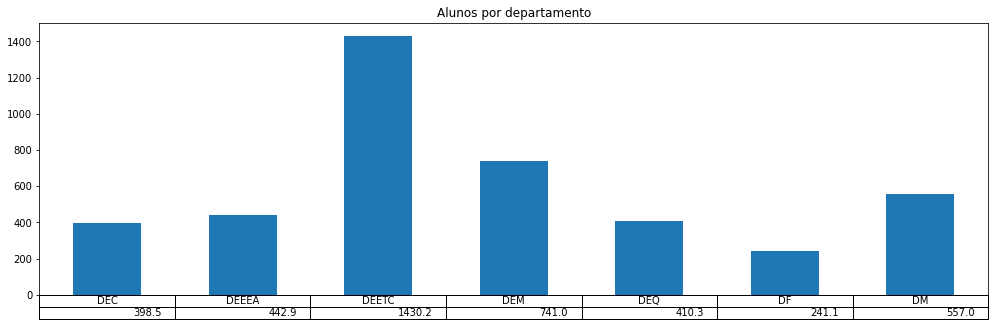

In [9]:
# Alunos por departamento
plot_table_series(alunos_per_dept, 'Alunos por departamento')

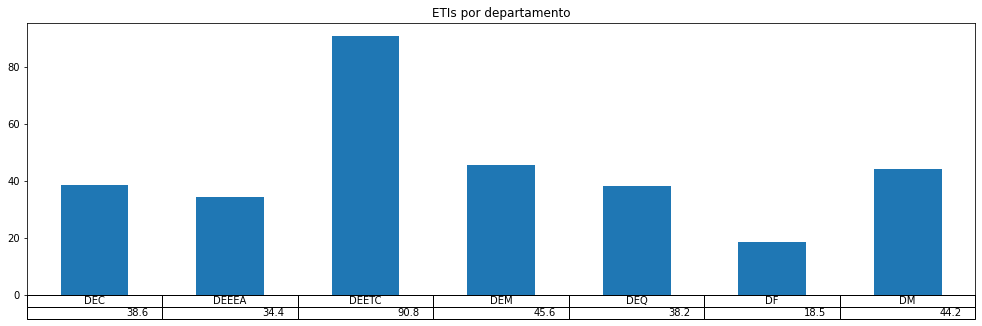

In [10]:
# ETIs por departamento
plot_table_series(eti_per_dept, 'ETIs por departamento')

## Visão geral

### Distribuição dos alunos pelos departamentos e cursos

In [11]:
# Distribuição dos alunos
dept_curso_alunos = pesos_dept_per_curso * alunos_per_curso
dept_curso_alunos = dept_curso_alunos.stack().reset_index()
dept_curso_alunos.rename(columns={'level_0': 'Departamento', 0: 'Alunos'}, inplace=True)

In [12]:
# Treemap interativo com a distribuição de alunos (isel -> departamentos -> cursos)
fig = px.treemap(np.round(dept_curso_alunos, 0), 
                 path=[px.Constant('ISEL'), 'Departamento', 'Curso'], values='Alunos')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25),  title={
        'text': "Distribuição dos Alunos pelos Departamentos/Cursos",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

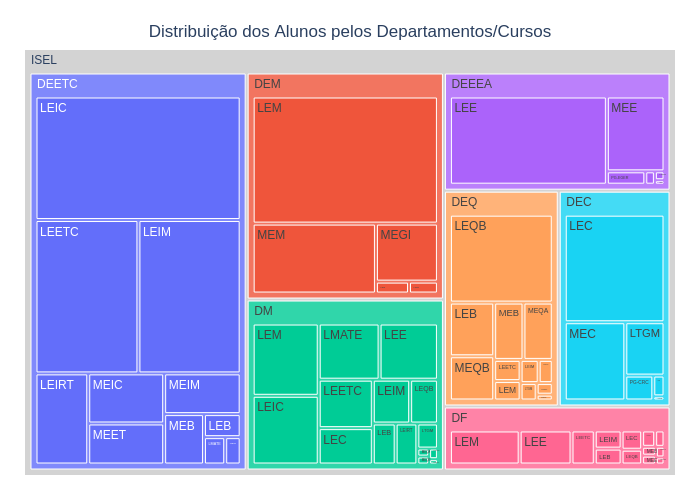

In [13]:
# Figura estática
fig.write_image('temp_image.png')
Image('temp_image.png',width=1600, height=800)

### Distribuição de horas de contacto pelos departamentos e cursos

In [14]:
# Distribuição das horas de contacto
horas_stacked = horas.stack().reset_index()
horas_stacked.rename(columns={'level_1': 'Departamento', 0: 'Horas'}, inplace=True)

In [15]:
# Treemap interativo com a distribuição das horas de contacto (isel -> departamentos -> cursos)
fig = px.treemap(np.round(horas_stacked, 0), 
                 path=[px.Constant('ISEL'), 'Departamento', 'Curso'], values='Horas')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25),  title={
        'text': "Distribuição das Horas de Contacto pelos Departamentos/Cursos",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

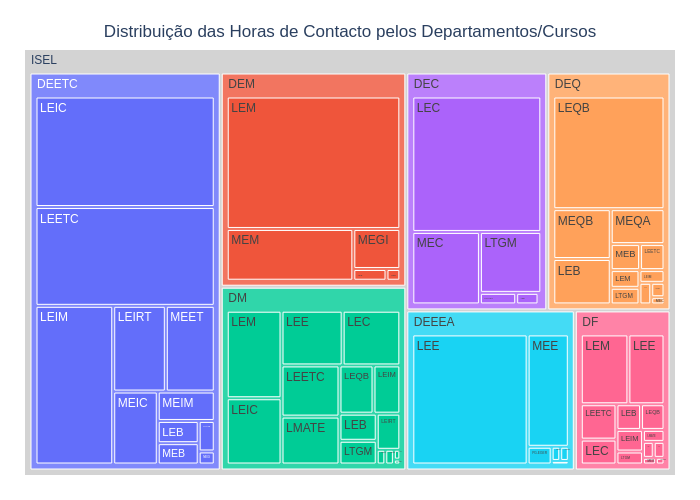

In [16]:
# Figura estática
fig.write_image('temp_image.png')
Image('temp_image.png',width=1600, height=800)

### Distribuição de ETIs pelos departamentos e categorias

In [17]:
# Distribuição dos ETIs por departamentos e categorias
dist_eti = docentes.drop(columns='Data Nascimento')
dist_eti['Categoria'] = dist_eti['Categoria'].apply(categorizar)

In [18]:
# Sunburst interativo com a distribuição dos ETIs (isel -> departamentos -> categorias)
fig = px.sunburst(dist_eti, path=[px.Constant('ISEL'), 'Departamento', 'Categoria'], values='ETI')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25),  
                  title={'text': "Distribuição dos ETIs pelos Departamentos/Categorias",
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  height=800)

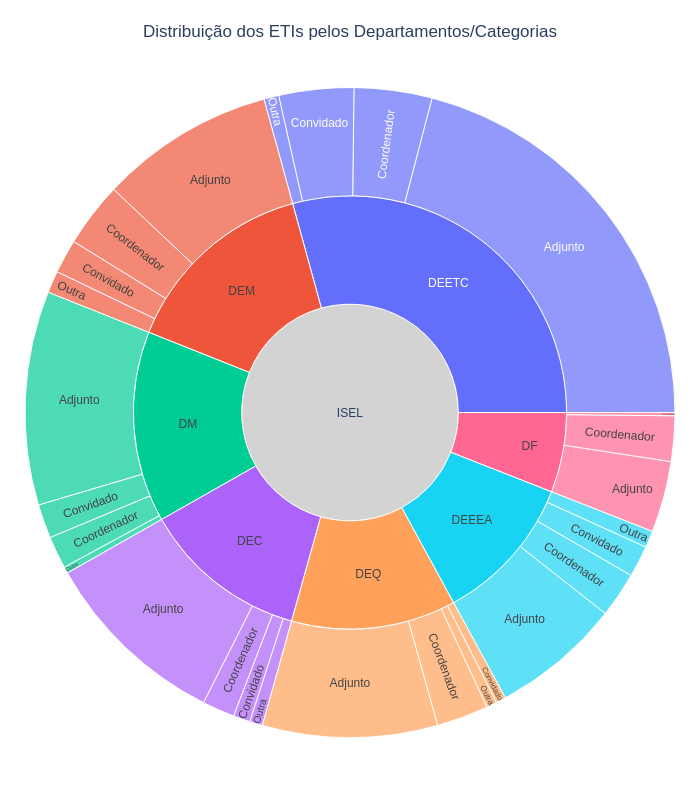

In [19]:
# Figura estática
fig.write_image('temp_image.png')
Image('temp_image.png',width=800, height=800)

In [20]:
# Sunburst interativo com a distribuição dos ETIs (isel -> categorias -> departamentos)
fig = px.sunburst(dist_eti, path=[px.Constant('ISEL'), 'Categoria', 'Departamento'], values='ETI')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25),  
                  title={
                      'text': "Distribuição dos ETIs pelas Categorias/Departamentos",
                      'x': 0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'},
                  height=800)

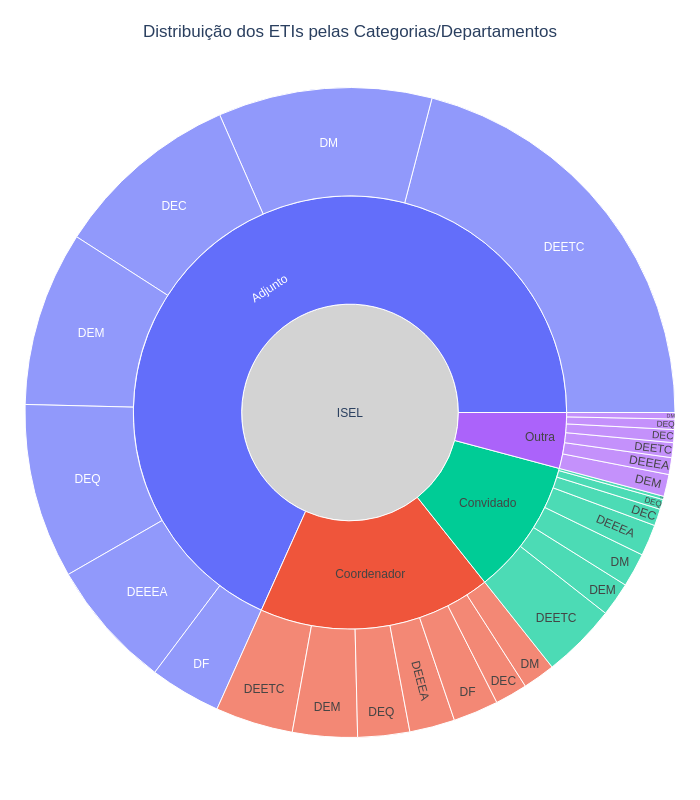

In [21]:
fig.write_image('temp_image.png')
Image('temp_image.png',width=800, height=800)

# Desigualdades entre departamentos

**Métrica:** rácio Alunos/ETI

**Observação:** Alunos/ETI = (Alunos/Hora_Contacto) x (Horas_Contacto/ETI)

**Ou seja**, um rácio elevado Alunos/ETI pode ter uma de duas causas (ou ambas):
*   Demasiados alunos por hora de contacto (**sobrecarga docente devido a turmas grandes**)
*   Demasiadas horas de contacto por ETI (**sobrecarga docente devido a excesso de horas letivas**) 

## Rácio Alunos/ETI por departamentos

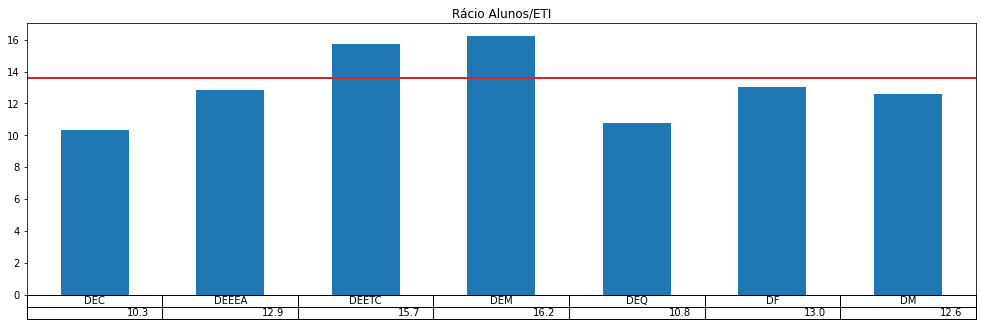

In [22]:
# Rácio Alunos/ETI por departamentos
plot_table_series(alunos_per_dept / eti_per_dept, 'Rácio Alunos/ETI', ref=alunos_per_eti_isel)

### Primeiro fator: Alunos por hora de contacto (dimensão relativa das turmas)

In [23]:
# Eficiência relativa dos departamentos/cursos
alunos_per_hora_isel = alunos_per_dept.sum() / horas_per_dept.sum()
horas_per_eti_isel = horas_per_curso.sum() / eti_per_dept.sum()
eff_alunos_per_hora_dept = 100 * alunos_per_dept / horas_per_dept / alunos_per_hora_isel
eff_horas_per_eti_dept = 100 * horas_per_dept / eti_per_dept / horas_per_eti_isel
eff_alunos_per_hora_curso = 100 * alunos_per_curso / horas_per_curso / alunos_per_hora_isel

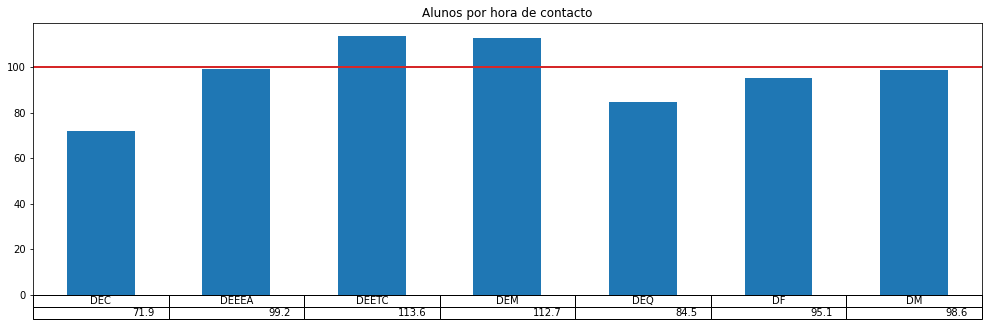

In [24]:
# Alunos por hora de contacto
plot_table_series(eff_alunos_per_hora_dept, 'Alunos por hora de contacto', ref=100)

### Segundo fator: Horas de contacto por ETI (carga letiva relativa)

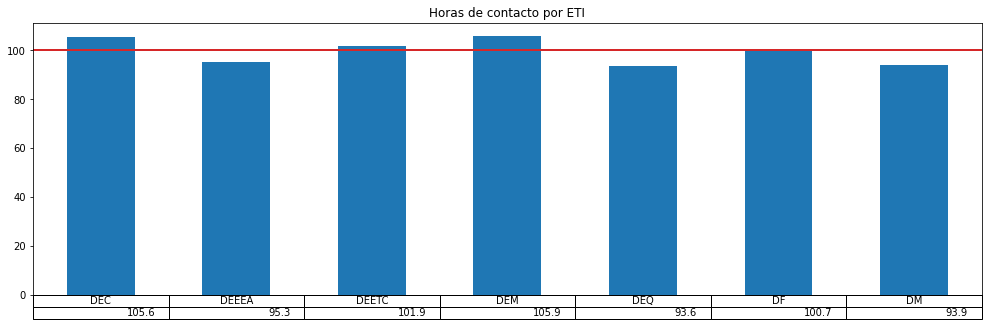

In [25]:
# Horas de contacto por ETI
plot_table_series(eff_horas_per_eti_dept, 'Horas de contacto por ETI', ref=100)

### Visão agregada dos dois fatores

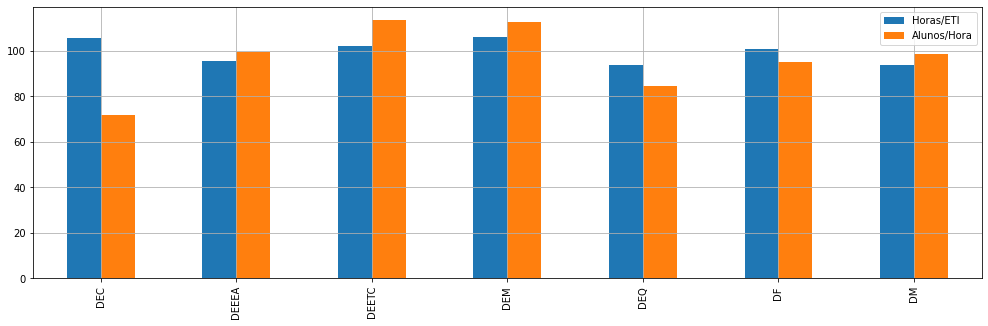

In [26]:
# Figura com a visualização dos dois fatores
fig, ax = plt.subplots(1, 1, figsize=(17,5))
df = pd.DataFrame(data={'Horas/ETI':eff_horas_per_eti_dept,'Alunos/Hora':eff_alunos_per_hora_dept})
df.plot(kind='bar', ax=ax)
ax.grid(True)

### Análise por curso (dimensão relativa das turmas)

#### Licenciaturas

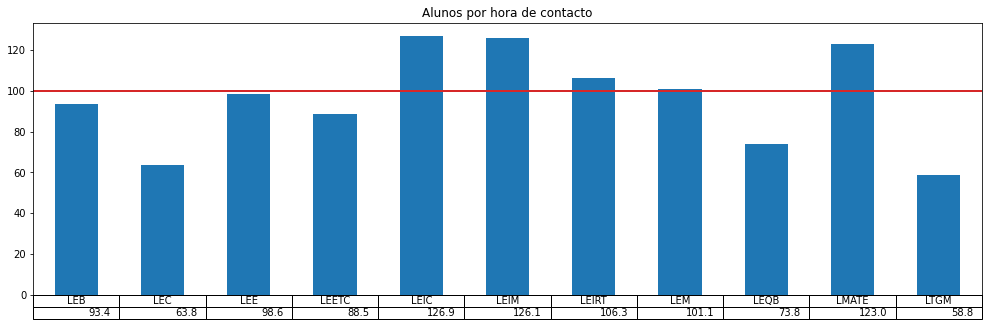

In [27]:
# Figura com eficiência relativa de cada curso (licenciatura)
plot_table_series(eff_alunos_per_hora_curso[:11], 'Alunos por hora de contacto', ref=100)

#### Mestrados

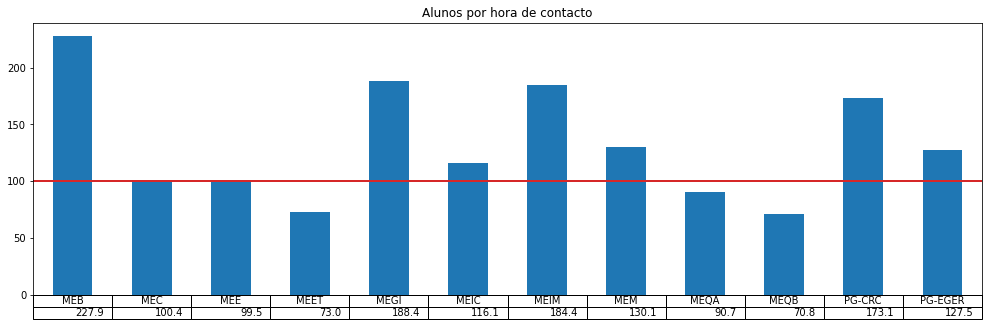

In [28]:
# Figura com eficiência relativa de cada curso (mestrado)
plot_table_series(eff_alunos_per_hora_curso[11:], 'Alunos por hora de contacto', ref=100)

## ETIs em Falta

In [29]:
# VIANA (Valor Ideal Atendendo ao Número de Alunos)
# FANA (em Falta Atendendo ao Número de Alunos)
alunos_per_eti_ideal = alunos_per_eti_isel
viana = alunos_per_dept / alunos_per_eti_ideal
fana = viana - eti_per_dept

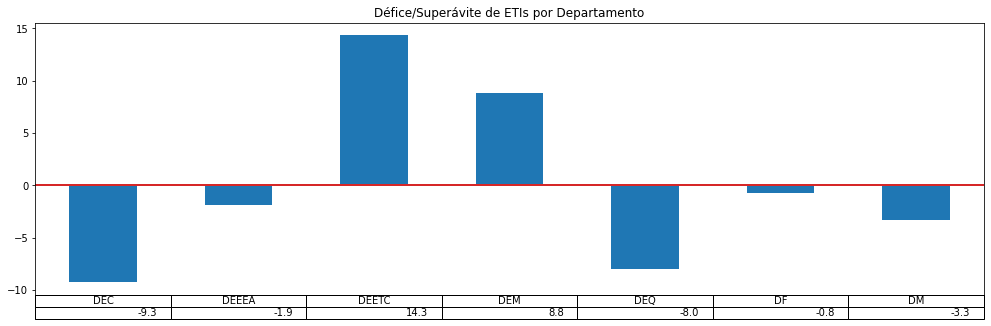

In [30]:
# Figura com défice/superávite de ETIs por departamento
plot_table_series(fana, 'Défice/Superávite de ETIs por Departamento', ref=0)

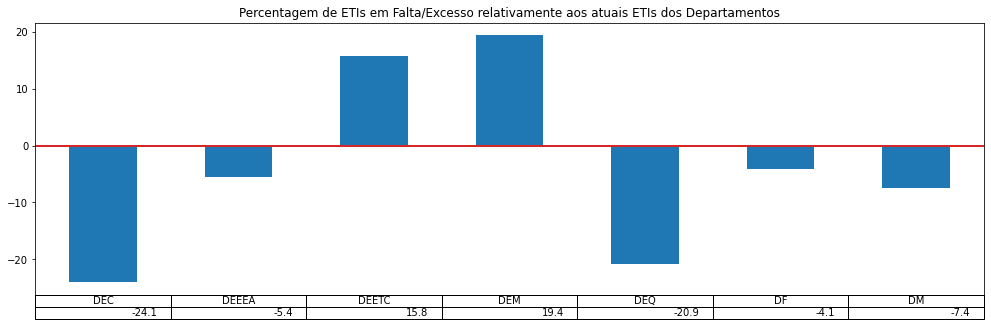

In [31]:
# Percentagem de ETIs em Falta/Excesso relativamente aos atuais ETIs dos Departamentos
s = 100*fana/eti_per_dept
plot_table_series(s, 'Percentagem de ETIs em Falta/Excesso relativamente aos atuais ETIs dos Departamentos', ref=0)